<a href="https://colab.research.google.com/github/TheHawk1093/EE5179_Lab/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
print(torch.__version__)
import torch.nn as nn
import numpy as np

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

2.8.0+cu126


In [8]:
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),               # Converts to float tensor [0,1] and adds channel dimension
    transforms.Lambda(lambda x: x.view(-1))  # Flatten tensor of dimension 28x28 to vector of size 784
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [9]:
print(f"The number of images in training dataset are {len(mnist_trainset)}")
print(f"The number of images in test dataset are {len(mnist_testset)}")

print(mnist_trainset.data.shape)
print(mnist_testset.data.shape)

The number of images in training dataset are 60000
The number of images in test dataset are 10000
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [10]:
print(mnist_trainset[0][0].shape)

torch.Size([784])


In [11]:
batch_size = 64
train_loader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

Model architecture:
- Input layer (784 neurons)
- Hidden layers with 500, 250, and 100 neurons using Sigmoid activations
- Output layer with 10 neurons (linear, raw logits)
- Glorot uniform weight initialization and zeros biases per assignment

In [12]:
class MLP(nn.Module):
  def __init__(self, input_dim = 784, hidden_dims = [500, 250, 100], output_dim = 10 ):

      layer_sizes = [input_dim] + hidden_dims + [output_dim]

      # Initialize weights and biases (Glorot initialization, zero biases)
      self.weights = []
      self.biases = []
      for i in range(len(layer_sizes) - 1):
          fan_in = layer_sizes[i]
          fan_out = layer_sizes[i + 1]
          limit = np.sqrt(6 / (fan_in + fan_out))
          W = np.random.uniform(-limit, limit, size=(fan_in, fan_out))
          b = np.zeros((1, fan_out))
          self.weights.append(W)
          self.biases.append(b)

  def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

  def sigmoid_derivative(self, x):
        return x * (1 - x)

  def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

  def forward(self, X):
        # Storing the inputs in arrays for backpropogation
        self.inputs = []
        self.z_values = []

        # Input layer to first hidden layer
        z1 = X @ self.weights[0] + self.biases[0]
        a1 = self.sigmoid(z1)

        # First hidden layer to second hidden layer
        z2 = a1 @ self.weights[1] + self.biases[1]
        a2 = self.sigmoid(z2)

        # Second hidden layer to third one
        z3 = a2 @ self.weights[2] + self.biases[2]
        a3 = self.sigmoid(z3)

        # Third hidden layer to output using Softmax
        z4 = a3 @ self.weights[3] + self.biases[3]
        output = self.softmax(z4)

        # Updating the vectors to store inputs and outputs before activation
        self.inputs = [X, a1, a2, a3]
        self.z_values = [z1, z2, z3, z4]

        return output

  def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        eps = 1e-9
        log_preds = np.log(y_pred + eps)
        loss = -np.sum(y_true * log_preds) / m
        return loss

  def backward(self, y_true, y_pred, learning_rate):
        m = y_true.shape[0]

        delta4 = (y_pred - y_true) / m  # output error

        dW4 = self.inputs[3].T @ delta4
        db4 = np.sum(delta4, axis=0, keepdims=True)

        delta3 = delta4 @ self.weights[3].T * self.sigmoid_derivative(self.inputs[3])
        dW3 = self.inputs[2].T @ delta3
        db3 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = delta3 @ self.weights[2].T * self.sigmoid_derivative(self.inputs[2])
        dW2 = self.inputs[1].T @ delta2
        db2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = delta2 @ self.weights[1].T * self.sigmoid_derivative(self.inputs[1])
        dW1 = self.inputs[0].T @ delta1
        db1 = np.sum(delta1, axis=0, keepdims=True)

        # Update weights and biases
        self.weights[3] -= learning_rate * dW4
        self.biases[3] -= learning_rate * db4

        self.weights[2] -= learning_rate * dW3
        self.biases[2] -= learning_rate * db3

        self.weights[1] -= learning_rate * dW2
        self.biases[1] -= learning_rate * db2

        self.weights[0] -= learning_rate * dW1
        self.biases[0] -= learning_rate * db1


In [13]:
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

Epoch 1/15, Loss: 2.3010
Epoch 2/15, Loss: 2.2848
Epoch 3/15, Loss: 2.2686
Epoch 4/15, Loss: 2.2429
Epoch 5/15, Loss: 2.1953
Epoch 6/15, Loss: 2.0928
Epoch 7/15, Loss: 1.8908
Epoch 8/15, Loss: 1.6267
Epoch 9/15, Loss: 1.3782
Epoch 10/15, Loss: 1.1831
Epoch 11/15, Loss: 1.0296
Epoch 12/15, Loss: 0.9102
Epoch 13/15, Loss: 0.8209
Epoch 14/15, Loss: 0.7511
Epoch 15/15, Loss: 0.6934


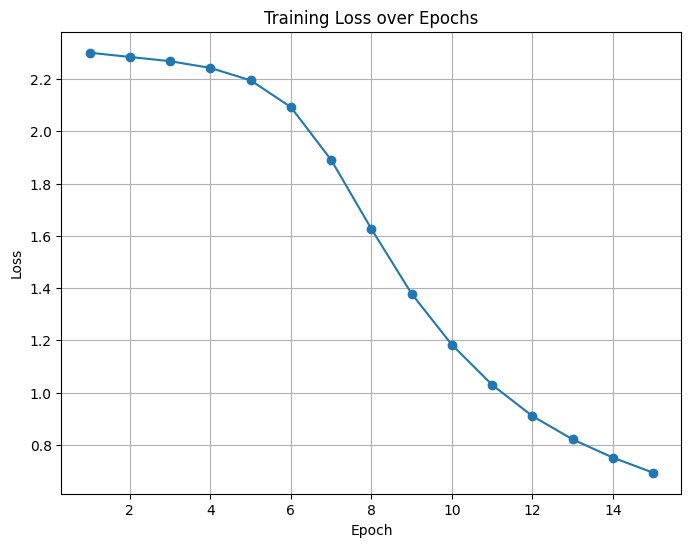

In [19]:
def train(model, train_loader, epochs=15, learning_rate=0.01):
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            # Convert tensors to numpy arrays
            X = images.numpy()
            y_indices = labels.numpy()
            y = one_hot_encode(y_indices)

            # Forward pass
            output = model.forward(X)

            # Compute loss
            loss = model.compute_loss(y, output)
            epoch_loss += loss
            batch_count += 1

            # Backward pass and update weights
            model.backward(y, output, learning_rate)

        avg_loss = epoch_loss / batch_count
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Plot training loss
    plt.figure(figsize=(8,6))
    plt.plot(range(1, epochs+1), loss_history, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

    return loss_history

# Initialization & training
model = MLP()
loss_history = train(model, train_loader)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
def predict(model, X):
    """
    Predict class labels for input X using trained model.
    """
    probs = model.forward(X)
    preds = np.argmax(probs, axis=1)
    return preds

def evaluate(model, X, y_true):
    """
    Evaluate model accuracy, print classification report and confusion matrix.
    y_true must be integer labels (not one-hot).
    """
    preds = predict(model, X)
    accuracy = np.mean(preds == y_true)
    print(f"Accuracy: {accuracy*100:.2f}%")

    print("Confusion Matrix:")
    print(confusion_matrix(y_true, preds))

    print("\nClassification Report:")
    print(classification_report(y_true, preds))

    return accuracy

def plot_training_curves(train_losses):
    """
    Plot training loss curve over epochs.
    """
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
    plt.title("Training Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


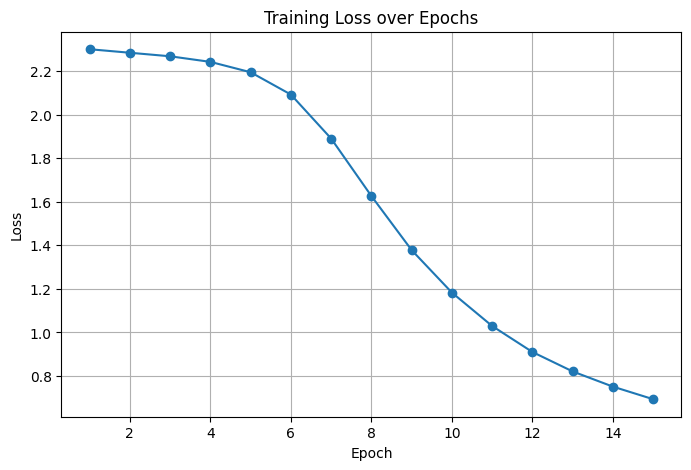

Accuracy: 81.30%
Confusion Matrix:
[[ 933    0    2    2    3   31    6    1    2    0]
 [   0 1107    7    6    0    1    3    2    8    1]
 [  19   27  822   32   26    6   31   10   50    9]
 [   4   10   34  802    1   63    1   22   66    7]
 [   1    3    2    0  779    0   23    3    5  166]
 [  41    3   22  118   11  601   28   20   25   23]
 [  28    3   20    0   20   17  869    0    1    0]
 [   2   38   11    0    8    7    0  888   25   49]
 [  24   23   58   59   19   41   11   23  672   44]
 [  16    7    2    4  186   10    2  109   16  657]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       980
           1       0.91      0.98      0.94      1135
           2       0.84      0.80      0.82      1032
           3       0.78      0.79      0.79      1010
           4       0.74      0.79      0.77       982
           5       0.77      0.67      0.72       892
           6       0.89      0.

np.float64(0.813)

In [22]:
plot_training_curves(loss_history)

# Convert test dataset to NumPy arrays, flatten, normalize, and get labels (as integers)
X_test_np = mnist_testset.data.numpy().reshape(-1, 28*28) / 255.0
y_test_np = mnist_testset.targets.numpy()

# Evaluate model performance on test set
evaluate(model, X_test_np, y_test_np)
